<a href="https://colab.research.google.com/github/aditis1204/Hypespectral_Visualization_Classification/blob/master/Hyperspectral_Analysis(Visualization)_%2B_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hyperspectral dataset EDA: Indian Pines
**Credits:** https://github.com/aditis1204/Hypespectral_Visualization_Classification


### Useful imports

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indianpines/IndianPines/Indian_pines_corrected.mat
/kaggle/input/indianpines/IndianPines/Indian_pines_gt.mat


In [3]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
from scipy.io import loadmat

import numpy as np
from tqdm import tqdm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.io as sio
import os

In [87]:
def read_data(dataset_name):                        # Loads Dataset
    # path = os.getcwd()
    if dataset_name == 'IP':
#         image = sio.loadmat("..\\source_code\\datasets\\IndianPines\\Indian_pines_corrected.mat")["indian_pines_corrected"]
#         label = sio.loadmat("..\\source_code\\datasets\\IndianPines\\Indian_pines_gt.mat")["indian_pines_gt"]
        image = loadmat("/kaggle/input/indianpines/IndianPines/Indian_pines_corrected.mat")["indian_pines_corrected"]
        label = loadmat("/kaggle/input/indianpines/IndianPines/Indian_pines_gt.mat")["indian_pines_gt"]
    elif dataset_name == 'UP':
#         image = sio.loadmat('..\\source_code\\datasets\\PaviaUniversity\\PaviaU.mat')['paviaU']
#         label = sio.loadmat('..\\source_code\\datasets\\PaviaUniversity\\PaviaU_gt.mat')['paviaU_gt']
        image = sio.loadmat("/kaggle/input/pavia/PaviaUniversity/PaviaU.mat")["paviaU"]
        label = sio.loadmat("/kaggle/input/pavia/PaviaUniversity/PaviaU_gt.mat")["paviaU_gt"]
    image = np.float64(image)
    label = np.array(label).astype(float)
    return image, label

dataset, ground_truth = read_data('IP')

In [88]:
# data shapes
print(f'Dataset: {dataset.shape}\nGround Truth: {ground_truth.shape}')

Dataset: (145, 145, 200)
Ground Truth: (145, 145)


In [89]:
# number of classes
num_classes = int(np.max(ground_truth))
num_classes

16

In [90]:
np.unique(ground_truth)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

#### Data visualization:

In [7]:
# plot random band
def plot_band(dataset):
    plt.figure(figsize=(8, 6))
    band_no = np.random.randint(dataset.shape[2])
    plt.imshow(dataset[:,:, band_no], cmap='viridis')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()

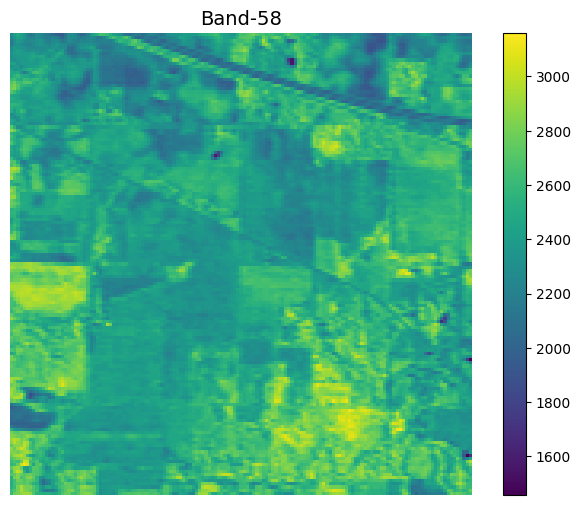

In [8]:
plot_band(dataset)

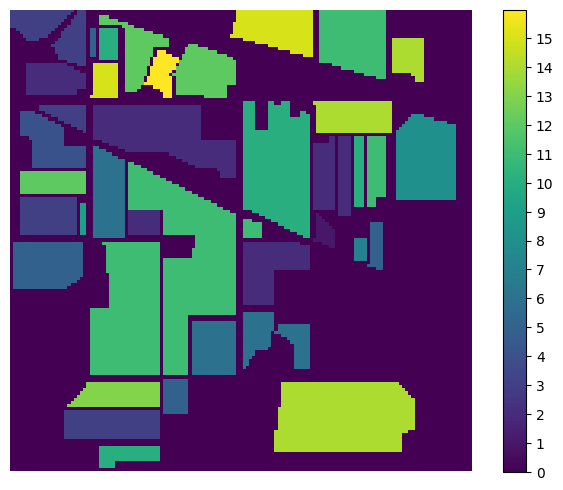

In [24]:
# show pixel labels (ground truth)
plt.figure(figsize=(8, 6))
plt.imshow(ground_truth, cmap='viridis')
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.show()

### Extracting Band Information:

In [97]:
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [98]:
df = extract_pixels(dataset, ground_truth)
df.sample(10)

100%|██████████| 200/200 [00:01<00:00, 179.30it/s]


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
19429,2978.0,4102.0,4012.0,3957.0,4260.0,4376.0,4278.0,4298.0,4116.0,3974.0,...,1014.0,1010.0,1025.0,1011.0,1016.0,1006.0,1007.0,1018.0,1003.0,0.0
3167,2737.0,4508.0,4607.0,4350.0,4878.0,5114.0,5297.0,5119.0,5059.0,4849.0,...,1065.0,1058.0,1059.0,1043.0,1043.0,1045.0,1027.0,1015.0,1019.0,0.0
10481,2595.0,3983.0,4034.0,4098.0,4393.0,4694.0,4678.0,4612.0,4587.0,4367.0,...,1061.0,1064.0,1060.0,1043.0,1046.0,1034.0,1031.0,1026.0,1000.0,0.0
15122,2759.0,4358.0,4587.0,4570.0,4856.0,5238.0,5430.0,5295.0,5266.0,5100.0,...,1123.0,1116.0,1129.0,1104.0,1068.0,1081.0,1060.0,1033.0,1019.0,11.0
13163,2759.0,3860.0,4033.0,4033.0,4274.0,4474.0,4513.0,4427.0,4211.0,4045.0,...,1023.0,1025.0,1024.0,1032.0,1018.0,1009.0,1007.0,999.0,1004.0,0.0
7024,3703.0,4385.0,4884.0,4799.0,5323.0,5777.0,5885.0,5845.0,5861.0,5602.0,...,1133.0,1128.0,1120.0,1112.0,1081.0,1099.0,1064.0,1033.0,1018.0,2.0
2056,3156.0,4008.0,4329.0,4188.0,4348.0,4651.0,4640.0,4533.0,4519.0,4270.0,...,1059.0,1049.0,1054.0,1046.0,1021.0,1048.0,1027.0,1015.0,1015.0,5.0
12771,3016.0,3857.0,3768.0,3955.0,4050.0,4284.0,4242.0,4090.0,4044.0,3825.0,...,1020.0,1016.0,1015.0,1018.0,1013.0,1018.0,1011.0,1003.0,995.0,0.0
5716,2744.0,4120.0,4139.0,4098.0,4331.0,4632.0,4559.0,4543.0,4433.0,4217.0,...,1034.0,1056.0,1050.0,1033.0,1030.0,1029.0,1025.0,1011.0,1009.0,0.0
19222,3314.0,3986.0,3920.0,3957.0,4069.0,4317.0,4349.0,4157.0,4104.0,3815.0,...,1016.0,1027.0,1014.0,1008.0,1015.0,1016.0,1012.0,1005.0,1000.0,0.0


In [12]:
# df.to_csv('Dataset.csv', index=False)

In [13]:
# Plot random pixel's spectral signature
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 201), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

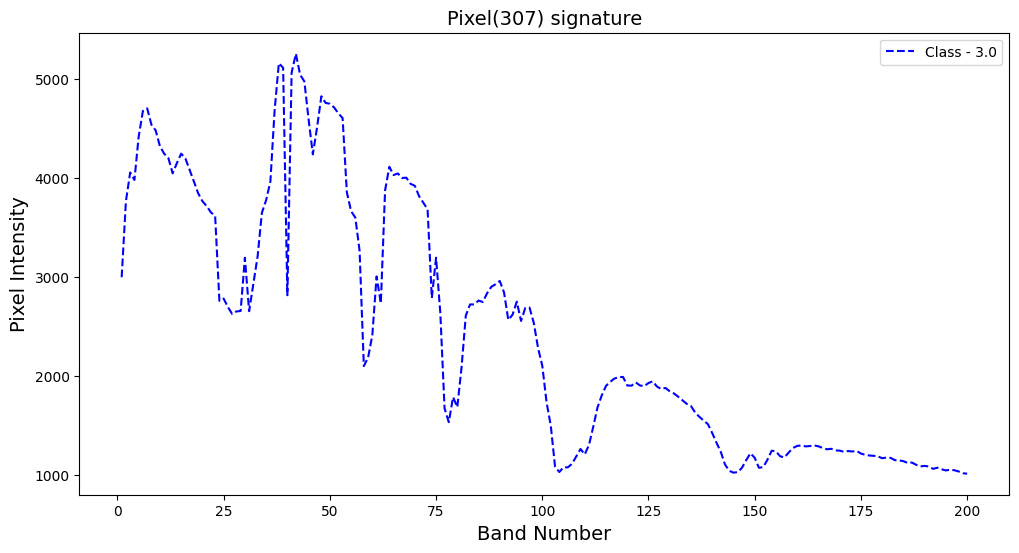

In [14]:
plot_signature(df)

### Band Information visualization:

In [25]:
print(f"Unique Class Labels: {np.sort(df.loc[:, 'class'].unique())}")

Unique Class Labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


In [28]:
df.loc[:, 'class'].value_counts()

class
0.0     10776
11.0     2455
2.0      1428
14.0     1265
10.0      972
3.0       830
6.0       730
12.0      593
5.0       483
8.0       478
15.0      386
4.0       237
13.0      205
16.0       93
1.0        46
7.0        28
9.0        20
Name: count, dtype: int64

**Note:** Class 0 pixels are background pixels and are usually removed from the dataset

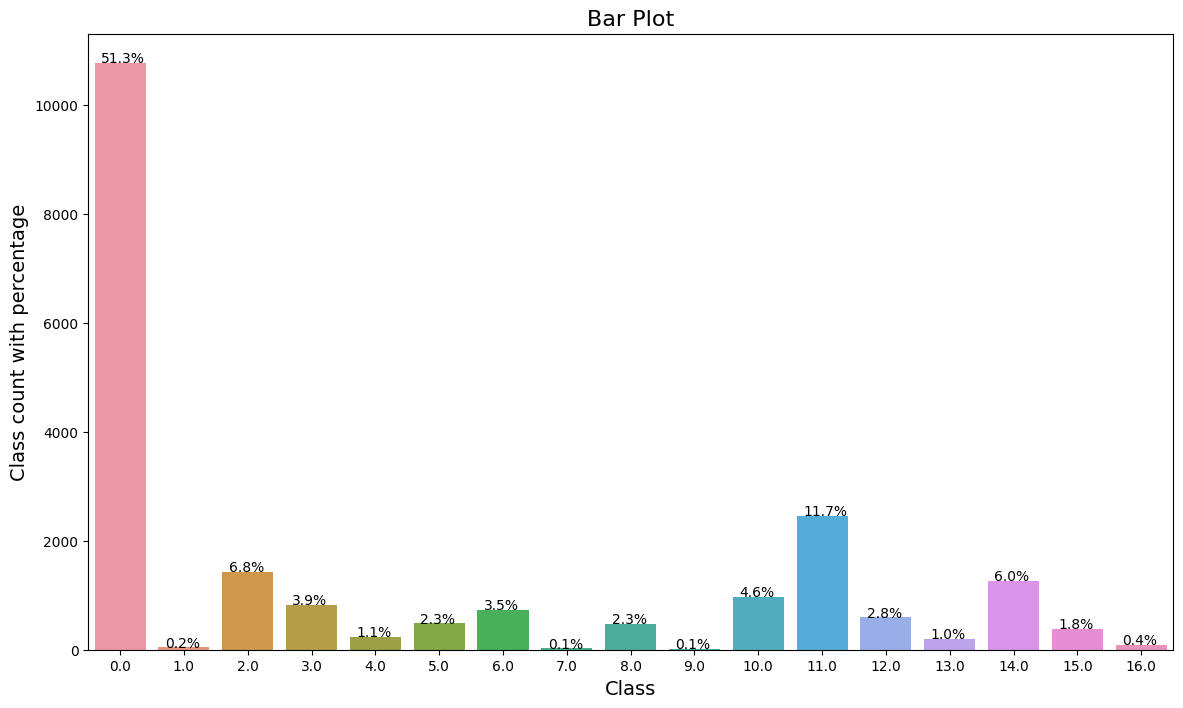

In [26]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x='class', data=df[['class']])

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))
#ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.ylabel('Class count with percentage', fontsize=14)

plt.xlabel('Class', fontsize=14)

plt.title('Bar Plot', fontsize=16)

plt.show()

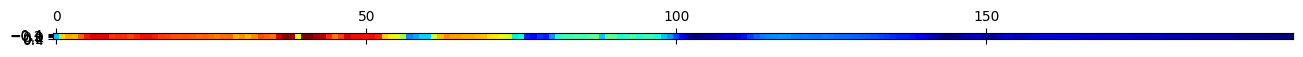

In [27]:
# Visualizing one  pixel
plt.matshow(df.iloc[1, :-1].values.reshape(1,200), cmap='jet')

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_pixel(pixel, n):
    ax = plt.gca()
    im = ax.imshow(pixel.reshape(10, 20), cmap = 'jet')
    plt.title(f'pixel - {n}')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

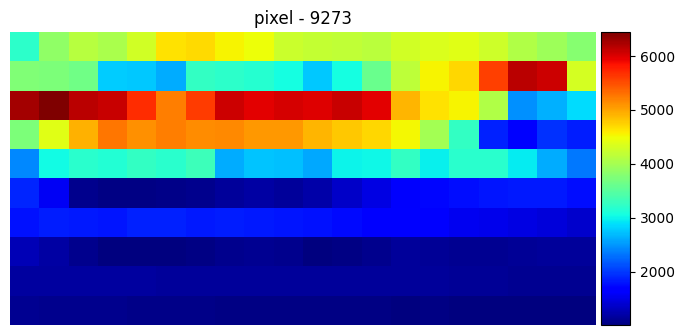

In [31]:
plt.figure(figsize=(8, 4))

rand_n = np.random.randint(df.shape[0])

plot_pixel(df.iloc[rand_n, :-1].values, rand_n)

Enter the band Number(1-200) : 2


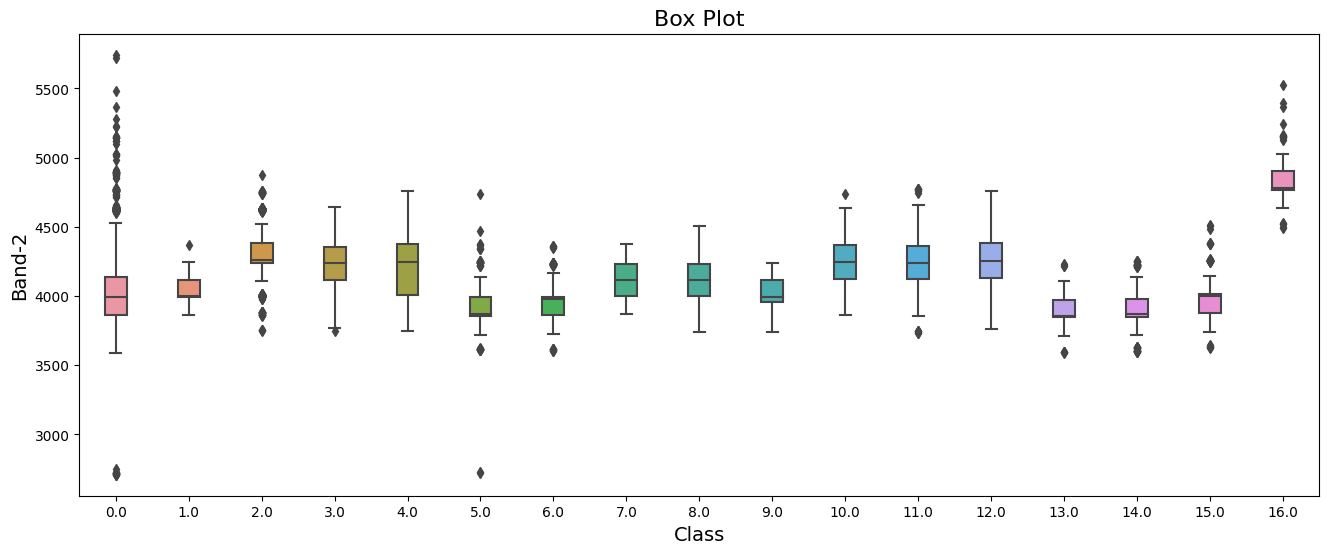

In [39]:
plt.figure(figsize=(16, 6))
n = int(input('Enter the band Number(1-200) :'))
sns.boxplot( x=df["class"], y=df["band-"+ str(n)], width=0.3);
plt.title('Box Plot', fontsize= 16)
plt.xlabel('Class', fontsize= 14)
plt.ylabel(f'Band-{n}', fontsize= 14)
plt.show()

In [40]:
print(f"Details of Band - {n}: \n\n{df['band-' + str(n)].describe()}")

Details of Band - 2: 

count    21025.000000
mean      4091.321237
std        230.390005
min       2709.000000
25%       3889.000000
50%       4106.000000
75%       4247.000000
max       5744.000000
Name: band-2, dtype: float64


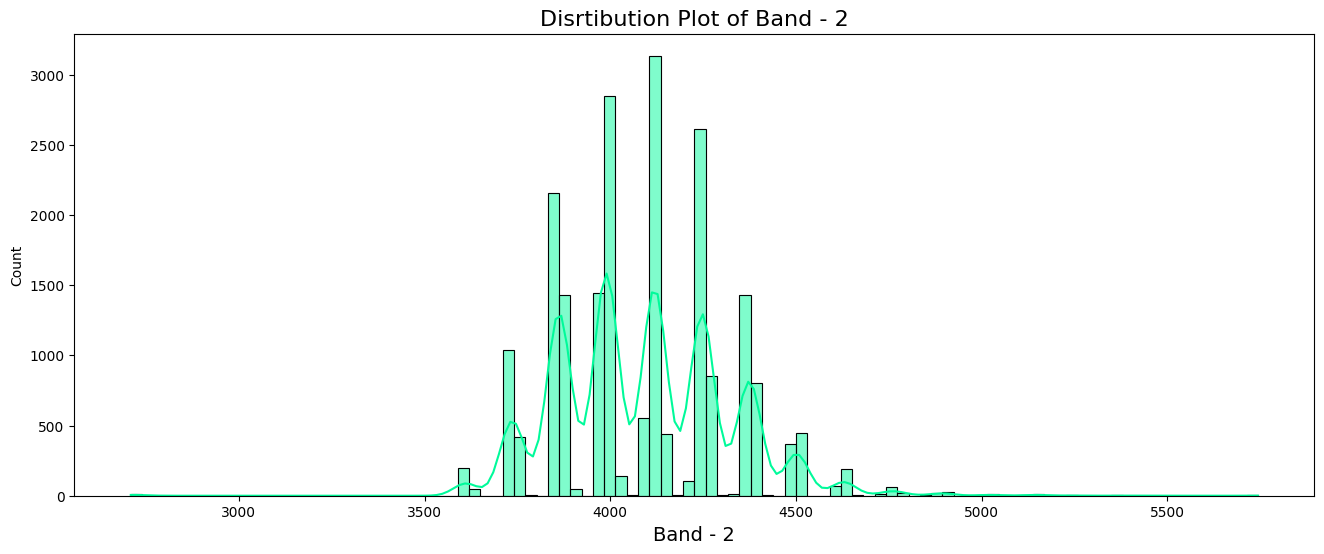

In [49]:
plt.figure(figsize=(16, 6))
sns.histplot(df['band-'+str(n)], color='mediumSpringGreen', bins=100, kde=True)
plt.xlabel('Band - '+str(n), fontsize=14)
plt.title('Disrtibution Plot of Band - '+str(n), fontsize=16)
plt.show()

### Implemetation of Dimensionality reduction using truncated SVD

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# !pip install seaborn
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split

In [53]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# df = pd.read_csv('Dataset.csv')
# df

In [54]:
X.shape, y.shape

((21025, 200), (21025,))

In [55]:
#kpca = KernelPCA(n_components = 50, kernel='poly', eigen_solver='arpack')
kpca = PCA(n_components = 50, whiten = True) 
#pca = PCA(n_components=numComponents, svd_solver='arpack')
principalComponents = kpca.fit_transform(X)

principalComponents.shape

(21025, 50)

In [63]:
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(principalComponents, y,  range(X.shape[0]), test_size = 0.15, random_state = 11)

In [64]:
X_train.shape, X_test.shape

((17871, 50), (3154, 50))

In [65]:
svm = SVC(kernel='rbf', degree = 11, gamma='scale', cache_size=1024*7)
svm.fit(X_train, y_train)

SVC(cache_size=7168, degree=11)

In [67]:
y_pred = svm.predict(X_test)

In [68]:
y_pred

array([ 2.,  2.,  0., ..., 11.,  0.,  0.])

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)*100}%')


Accuracy: 74.95244134432467%


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

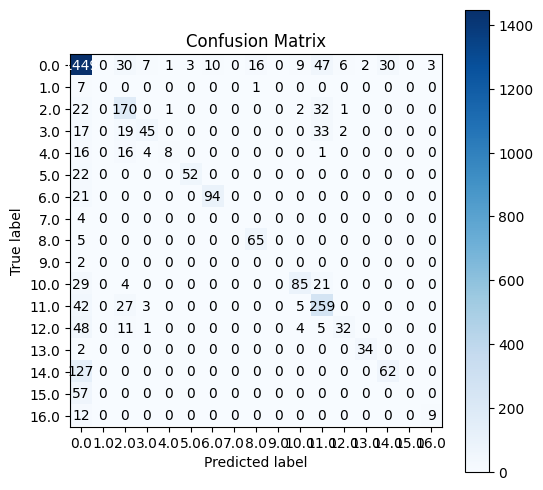

In [71]:
! pip install -q scikit-plot
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(6,6))

In [72]:
# print(confusion_matrix(y_test,y_pred))
print('Classification report:\n',classification_report(y_test,y_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       0.77      0.90      0.83      1613
         1.0       0.00      0.00      0.00         8
         2.0       0.61      0.75      0.67       228
         3.0       0.75      0.39      0.51       116
         4.0       0.80      0.18      0.29        45
         5.0       0.95      0.70      0.81        74
         6.0       0.90      0.82      0.86       115
         7.0       0.00      0.00      0.00         4
         8.0       0.79      0.93      0.86        70
         9.0       0.00      0.00      0.00         2
        10.0       0.81      0.61      0.70       139
        11.0       0.65      0.77      0.71       336
        12.0       0.78      0.32      0.45       101
        13.0       0.94      0.94      0.94        36
        14.0       0.67      0.33      0.44       189
        15.0       0.00      0.00      0.00        57
        16.0       0.75      0.43      0.55        21

  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



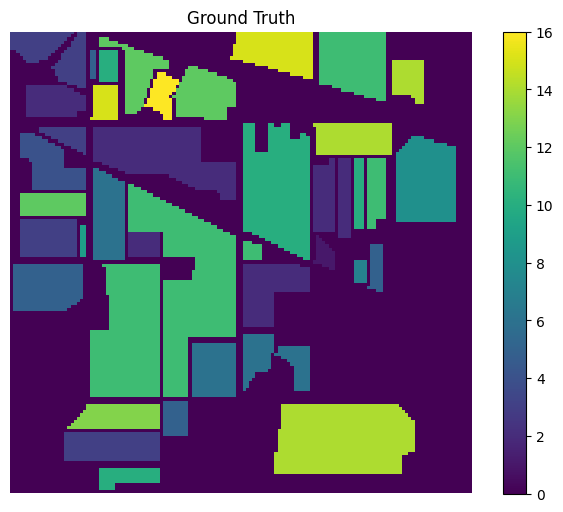

In [73]:
plt.figure(figsize=(8, 6))
plt.imshow(df.iloc[:, -1].values.reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Ground Truth')
plt.savefig('ground_truth.png')
plt.show()

In [110]:
pre = y_pred

clmap = [0]*X.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = y[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 3154/3154 [00:00<00:00, 1446564.77it/s]


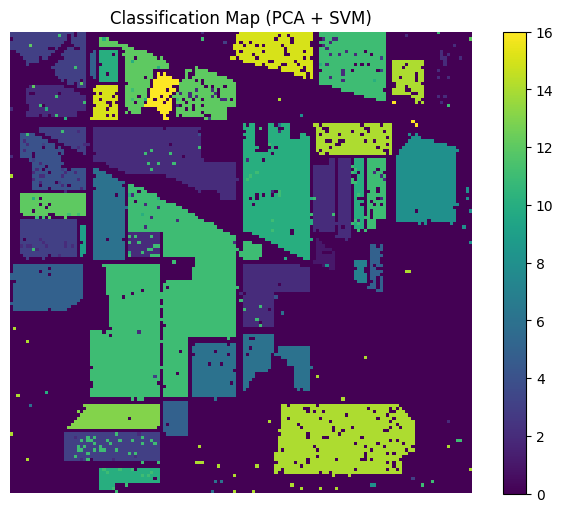

In [111]:
plt.figure(figsize=(8, 6))
plt.imshow(np.array(clmap).reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Classification Map (PCA + SVM)')
plt.savefig('Classification_map.png')
plt.show()

#### PCA + SVM with the class: 0 dropped

In [99]:
new_df = df.drop(df[df['class'] == 0].index)

In [101]:
print(f"Unique Class Labels: {np.sort(new_df.loc[:, 'class'].unique())}")

Unique Class Labels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


In [104]:
new_x = new_df.iloc[:, :-1].values
new_y = new_df.iloc[:, -1].values
new_x.shape, new_y.shape

((10249, 200), (10249,))

In [105]:
#kpca = KernelPCA(n_components = 50, kernel='poly', eigen_solver='arpack')
new_kpca = PCA(n_components = 50, whiten = True) 
#pca = PCA(n_components=numComponents, svd_solver='arpack')
new_principalComponents = kpca.fit_transform(new_x)

new_principalComponents.shape

(10249, 50)

In [106]:
new_X_train, new_X_test, new_y_train, new_y_test, new_indices_train, new_indices_test  = train_test_split(new_principalComponents, new_y,  range(new_x.shape[0]), test_size = 0.15, random_state = 11)
new_X_train.shape, new_X_test.shape, 

((8711, 50), (1538, 50))

In [107]:
new_svm = SVC(kernel='rbf', degree = 11, gamma='scale', cache_size=1024*7)
new_svm.fit(new_X_train, new_y_train)

SVC(cache_size=7168, degree=11)

In [108]:
new_y_pred = new_svm.predict(new_X_test)

In [109]:
new_y_pred

array([ 8.,  3., 11., ..., 12., 11.,  3.])

Accuracy: 80.29908972691807%


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

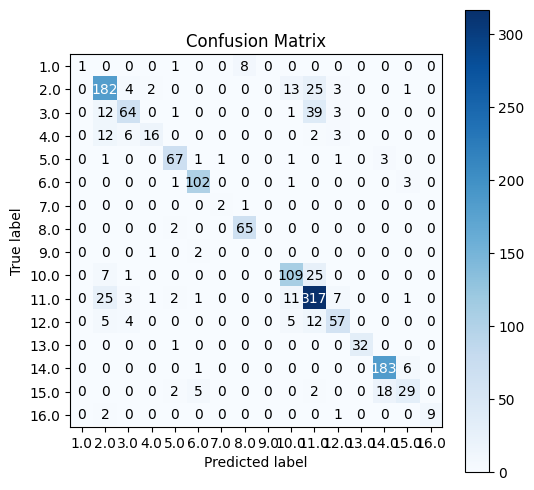

In [113]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f'Accuracy: {accuracy_score(new_y_test, new_y_pred)*100}%')
skplt.metrics.plot_confusion_matrix(
    new_y_test, 
    new_y_pred,
    figsize=(6,6))

In [115]:
print('Classification report:\n',classification_report(new_y_test, new_y_pred))

Classification report:
               precision    recall  f1-score   support

         1.0       1.00      0.10      0.18        10
         2.0       0.74      0.79      0.76       230
         3.0       0.78      0.53      0.63       120
         4.0       0.80      0.41      0.54        39
         5.0       0.87      0.89      0.88        75
         6.0       0.91      0.95      0.93       107
         7.0       0.67      0.67      0.67         3
         8.0       0.88      0.97      0.92        67
         9.0       0.00      0.00      0.00         3
        10.0       0.77      0.77      0.77       142
        11.0       0.75      0.86      0.80       368
        12.0       0.76      0.69      0.72        83
        13.0       1.00      0.97      0.98        33
        14.0       0.90      0.96      0.93       190
        15.0       0.72      0.52      0.60        56
        16.0       1.00      0.75      0.86        12

    accuracy                           0.80      1538
  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

